In [1]:
%%capture cap --no-stderr
# capture minimap2 path from conda env
!source activate isoformant && which minimap2

In [6]:
# set module path relative to test directory
import sys,os
sys.path.append(os.path.abspath('../isoformant/'))

# import isoformant
from isoformant import *

# input variables
ncore=1 # CPUs 
minimap2_path = cap.stdout.strip() # minimap2 executable path
ref_fa = '../example/SIRV_isoforms_multi-fasta_170612a.fasta' # reference genome 
gene_track = '../example/SIRV_isoforms_multi-fasta-annotation_C_170612a_corrected_norm.bed' # Optional, isoform annotations
dest_dir = './outputs' # output directory 


#### Module 1: Process region-of-interest (ROI) alignments

In [8]:
# ingest list of BAM files
bams_list = [
    '../example/SIRV1_cDNA_sorted.bam',
    '../example/SIRV1_RNA_sorted.bam',
]

# assign region-of-interest (ROI)
chrom, start, end = ('SIRV1', 1, 12643)

# process BAM
combined_csv, combined_bam = preprocess_reads(bams_list, 
                                              chrom, # ROI
                                              start, # ROI
                                              end, # ROI
                                              dest_dir, 
                                              max_reads=1000, # limits reads to 'max_reads' per BAM
                                              ncore=ncore, # CPUs
                                              qual_cutoff=15, # min. mean base quality
                                              len_cutoff=500) # min. read length

380it [00:00, 5422.39it/s]

>Module: Process BAM files
>>Task: Filter BAM file
	BAM = ../example/SIRV1_cDNA_sorted.bam
	# of records in ROI: 380
	# passing: 353



306it [00:00, 7717.77it/s]

>>Task: Filter BAM file
	BAM = ../example/SIRV1_RNA_sorted.bam
	# of records in ROI: 306
	# passing: 183


#### Module 2: Long-read k-merization and cluster reads in k-mer space 

8it [00:00, 79.95it/s]

>Module: Read k-merization
>>Task: k-merize CSV reads
	k = 7


366it [00:01, 224.64it/s]


>>Task: Convert k-mer pandas dataframe to anndata object
>>Task: PCA
	# of PCs = 100


/gstore/home/led13/.conda/envs/isoformant/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample_id' as categorical


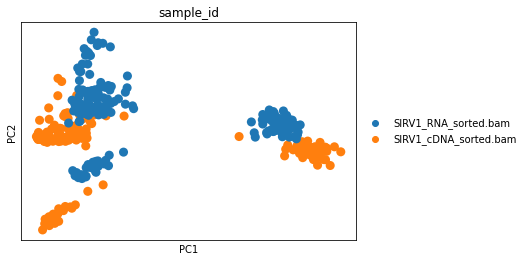

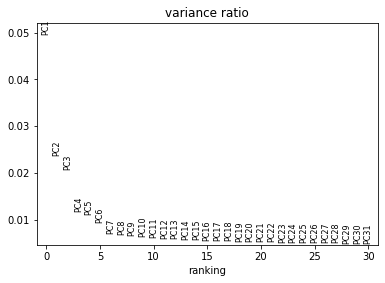

In [20]:
# k-merize sequences and create adata object
adata = kmerize(combined_csv, 
                ksize = 7 # k-mer size
               )

# pca pipeline: dimensionality reduction
pca_pipeline(adata, groupby_list=['sample_id'], n_comps=100, plot=True)

# use Scanpy's variance ratio function to determine appropiate number of PCs for analysis
sc.pl.pca_variance_ratio(adata)

>>Task: UMAP
	# of PCs = 20
	# of neighbors = 10
	Minimum distance = 0.5
	Resolution = 1


/gstore/home/led13/.conda/envs/isoformant/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'leiden' as categorical


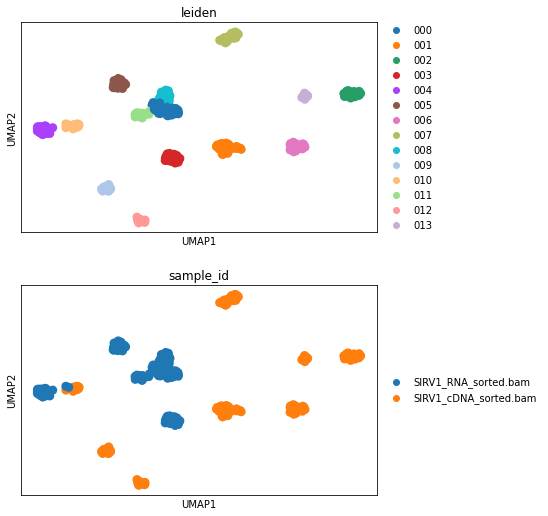

In [21]:
# umap pipeline: clustering
umap_pipeline(adata, groupby_list=['leiden', 'sample_id'], 
              n_pcs = 20, # number of PCs
              n_neighbors = 10, 
              min_dist = 0.5, 
              resolution = 1, # clustering resolution
              plot = True
             )

In [6]:
# # save figure to ./figures/umap{suffix}.pdf using Scanpy's umap function
# suffix = 'your_suffix'
# sc.pl.umap(adata, color=['sample_id','leiden'], ncols=1, save = suffix)

# inject PAF clustering labels

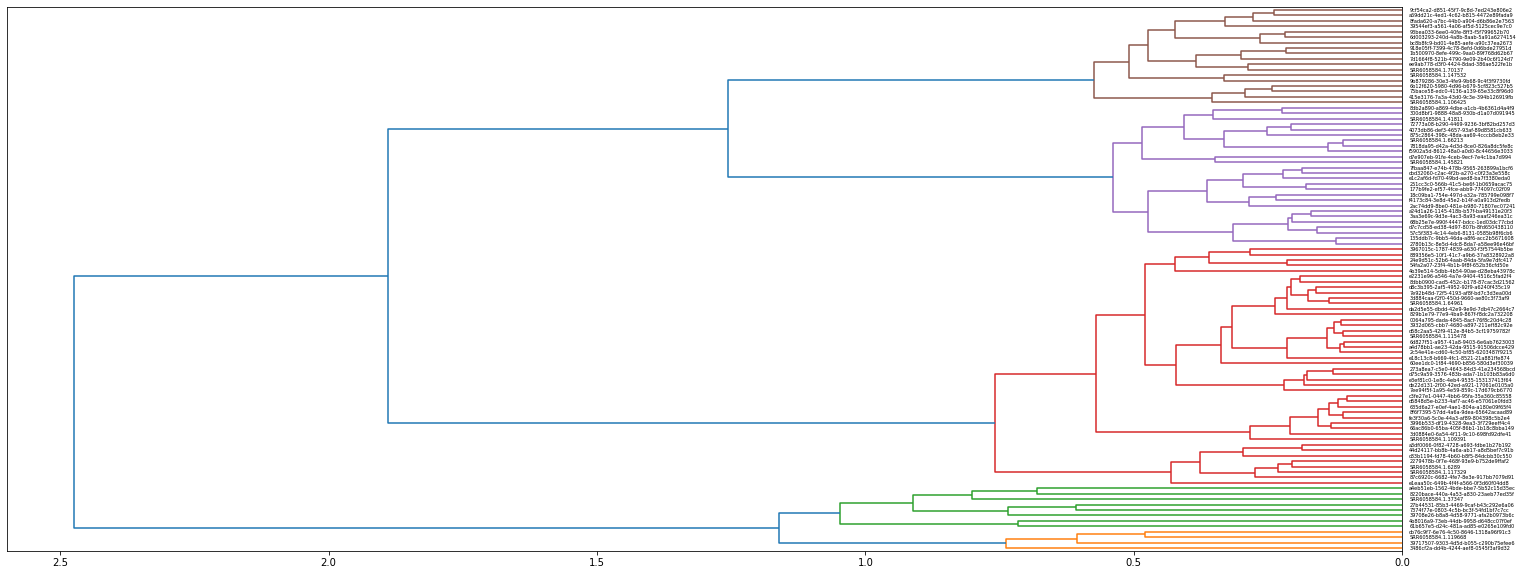

In [49]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import itertools
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt

# ingest PAF
inpfa = '/gne/data/dnaseq/analysis/labstaff/led13/outputs/DL20211207_ava_testing/test100.ava.paf'
paf_df = pd.read_csv(inpfa, sep='\t',header=None,
                     names=['qname','qlen','qstart','qend','strand',
                            'tname','tlen','tstart','tend','num_match','num_base','qual',
                            'type','num_minizr','chain_score','divergence','qrep_len'
                           ]
                    )
paf_df['type']=[x.split(':')[-1] for x in paf_df['type']]
paf_df['num_minizr']=[int(x.split(':')[-1]) for x in paf_df['num_minizr']]
paf_df['chain_score']=[int(x.split(':')[-1]) for x in paf_df['chain_score']]
paf_df['divergence']=[float(x.split(':')[-1]) for x in paf_df['divergence']]
paf_df['qrep_len']=[int(x.split(':')[-1]) for x in paf_df['qrep_len']]
paf_df['blast_identity'] = paf_df['num_match']/paf_df['num_base']

# filter on max/min feature values
FOI = 'divergence'
ascending = True
paf_df = paf_df.sort_values(FOI, ascending=ascending).groupby(['qname','tname']).head(1)

# create 0-value 3-column DF
reads = list(set(paf_df['qname'].tolist() + paf_df['tname'].tolist()))
ava_reads = list(itertools.product(reads, repeat=2))
ava_reads_df = pd.DataFrame({'qname':[x[0] for x in ava_reads],
           'tname':[x[1] for x in ava_reads],
           'val':[0]*len(ava_reads)
          })

# merge FOI values into 3-column DF
ava_filled = (pd.merge(paf_df.loc[:,['qname','tname',FOI]].rename(columns={FOI:'val'}),
                 ava_reads_df,
                 'right',
                 ['qname','tname',]
                )
#               .replace(np.nan, 0)
              .drop('val_y',1)
              .rename(columns={'val_x':FOI})
             )

# pivot to square matrix
ordered_reads = ava_filled['qname'].drop_duplicates().tolist()
cats = CategoricalDtype(ordered_reads, ordered=True)
ava_filled['qname'] = ava_filled['qname'].astype('category')
ava_filled['tname'] = ava_filled['tname'].astype('category')
sq_ava_filled = ava_filled.pivot(index='qname', columns='tname', values=FOI)
sq_ava_filled = np.nan_to_num(np.array(sq_ava_filled))
sq_ava_arr = sq_ava_filled + sq_ava_filled.T

# cluster
Z = linkage(pdist(sq_ava_arr), 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels = ordered_reads, orientation='left', color_threshold=1.1)

In [63]:
paf_df

,qname,qlen,qstart,qend,strand,tname,tlen,tstart,tend,num_match,num_base,qual,type,num_minizr,chain_score,divergence,qrep_len,blast_identity
3030,2ac74dd9-8be0-481e-b980-71807ec07241,2663,464,1481,+,d7c7cd58-ed38-4d97-807b-8fd650438110,1126,73,1107,847,1041,0,S,233,838,0.0253,55,0.813641
810,4073db86-def3-4657-93af-89d8581cb633,1126,27,1098,+,61b657e5-d24c-481a-ad85-e0265e109fd0,1706,27,1703,909,1683,0,S,222,824,0.0282,58,0.540107
131,c3fe27e1-0447-4bb6-95fa-35a360c85558,1540,16,1054,-,d7c7cd58-ed38-4d97-807b-8fd650438110,1126,61,1120,859,1073,0,S,220,849,0.0303,42,0.800559
1236,135ddb7c-9bb5-46da-a8f6-acc2b5671608,1726,31,1090,-,d7c7cd58-ed38-4d97-807b-8fd650438110,1126,61,1102,848,1070,0,S,214,840,0.0304,62,0.792523
818,4073db86-def3-4657-93af-89d8581cb633,1126,20,1098,+,da2d5e55-dbdd-42e9-9e9d-7db47c2664c7,1687,21,1685,875,1674,0,S,216,792,0.0304,58,0.522700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,SRR6058584.1.109391,1294,149,1125,+,SRR6058584.1.115478,1415,301,1271,122,991,0,S,13,113,0.1956,0,0.123108
4990,27b44531-85b3-4469-9caf-b43c292e6a06,1515,93,1408,+,SRR6058584.1.109391,1294,28,1204,181,1315,0,S,17,153,0.1962,39,0.137643
5222,SRR6058584.1.115478,1415,38,1273,+,SRR6058584.1.41811,1462,43,1315,127,1279,0,S,15,115,0.1986,18,0.099296
2523,44d24117-bb8b-4a6a-ab17-a8d5bef7c91b,1725,140,1499,+,SRR6058584.1.115478,1415,43,1271,141,1359,0,S,16,118,0.1999,59,0.103753


... storing 'hclust' as categorical


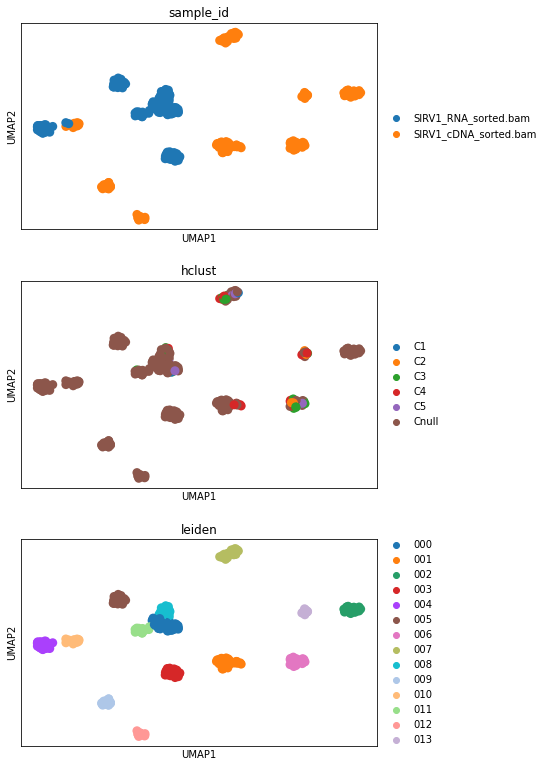

>>Task: Create visualization BAM files
	Maximum number of records per BAM = 10


In [59]:
# re-label and create new outputs
relabel_d = {}
for key,value in zip(dn['ivl'],dn['leaves_color_list']):
    relabel_d[key]=value
adata.obs['hclust'] = adata.obs['read_name'].map(relabel_d).replace(np.nan, 'Cnull')

sc.pl.umap(adata,
                  color = ['sample_id','hclust','leiden'],
                  ncols=1
                 )

# Create BAMs for visualization
label_target = 'hclust'
bam_dict, seq_dict = create_viz_bams(adata, combined_bam, dest_dir + '/viz', cluster_label=label_target, bam_n=10, ncore=ncore)

#### Module 3: Consensus (CNS) calling using clustered reads
Relative read abundance in parentheses

 17%|█▋        | 1/6 [00:00<00:02,  1.67it/s]

>Module: Consensus calling
>>Task: POA step


100%|██████████| 6/6 [00:01<00:00,  4.08it/s]


>>Task: Align sequences


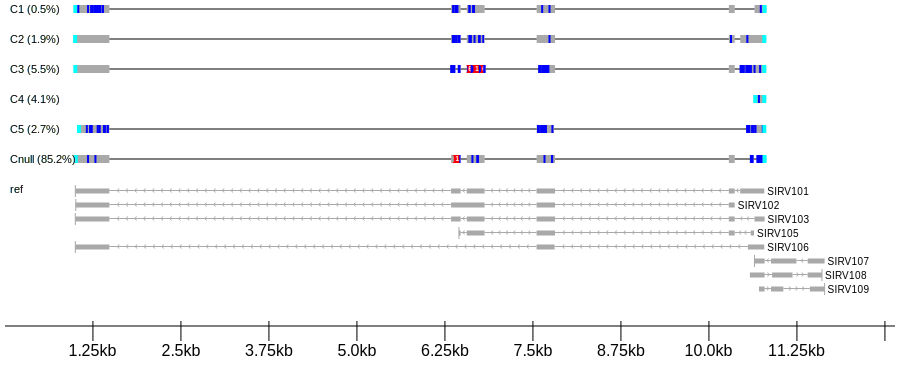

In [60]:
# Consensus calling: POA consensus and mapping with minimap2
sorted_cnsbam, cns_dict = cns(minimap2_path,
                                    seq_dict, 
                                    dest_dir + '/cns', 
                                    ref_fa,
                                    cluster_label = label_target, 
                                    ncore = ncore,
                                    sirv=True
                                   )
# include read abundances
abund_d = adata.obs[label_target].value_counts(normalize = True).to_dict()
keys = cns_dict.keys()
cns_dict_tmp = {}
for key in cns_dict.keys():
    abund_val = round(abund_d.get(key)*100,1)
    cns_dict_tmp[f'{key} ({abund_val}%)'] = cns_dict.get(key)
cns_dict = cns_dict_tmp 

# Visualize set of CNS
track_dict={**cns_dict, **{'ref':gene_track}}
track_dict=collections.OrderedDict(sorted(track_dict.items()))
plot_tracks(track_dict, chrom, int(start), int(end), ref_fa, save=None) #save plot by replacing None with destination path

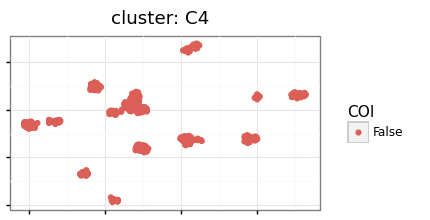

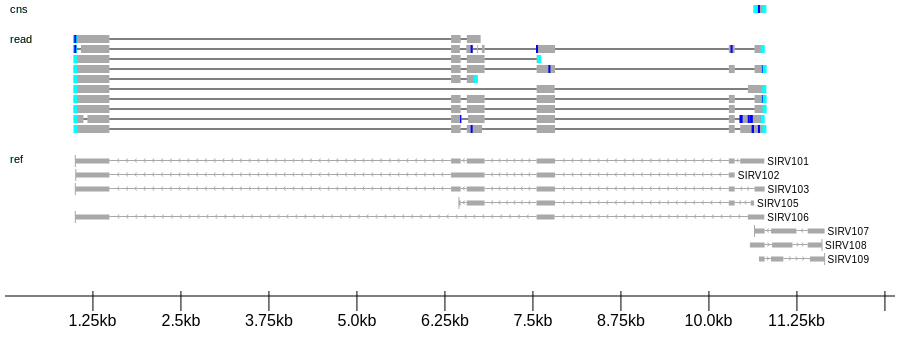

In [62]:
# Visualize single cluster
COI = 'C4'
plot_highlight_COI(adata, COI, 'leiden')
track_dict={'cns':cns_dict.get([x for x in cns_dict.keys() if x.startswith(COI)][0]), 
            'read':bam_dict.get(COI), 
            'ref':gene_track}
plot_tracks(track_dict, chrom, int(start), int(end), ref_fa, save=None) #save plot by replacing None with destination path

#### Module 4: Differential isoform usage hypothesis testing

>>Task: Chi-sqaured test
	Considering ['SIRV1_RNA_sorted.bam', 'SIRV1_cDNA_sorted.bam'] from class = "sample_id"


/gstore/home/led13/git/isoformant/isoformant/isoformant.py:602: UserWarning: Chi-squared test overrejects when any observed frequency less than 5


,leiden,pval,pval_adj
1,000,1.537460e-12,2.152444e-11
3,001,1.973175e-09,2.762445e-08
9,002,1.541726e-08,2.158416e-07
8,003,4.320463e-08,6.048648e-07
2,004,7.237830e-08,1.013296e-06
10,005,7.237830e-08,1.013296e-06
0,007,2.034555e-07,2.848376e-06
5,006,2.034555e-07,2.848376e-06
11,008,3.414174e-07,4.779843e-06
7,009,7.744216e-06,1.084190e-04


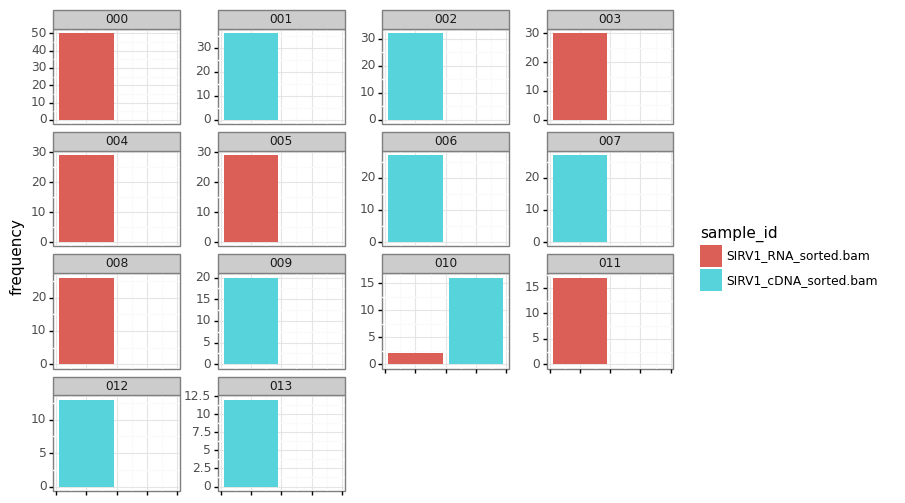

,leiden,sample_id,frequency,group_rank
0,000,SIRV1_RNA_sorted.bam,50,1
1,001,SIRV1_cDNA_sorted.bam,36,1
2,002,SIRV1_cDNA_sorted.bam,32,1
3,003,SIRV1_RNA_sorted.bam,30,1
4,004,SIRV1_RNA_sorted.bam,29,1
5,005,SIRV1_RNA_sorted.bam,29,1
6,006,SIRV1_cDNA_sorted.bam,27,1
7,007,SIRV1_cDNA_sorted.bam,27,1
8,008,SIRV1_RNA_sorted.bam,26,1
9,009,SIRV1_cDNA_sorted.bam,20,1


In [13]:
# Chi-squared goodness-of-fit test
results_df = balanced_chisq_test(adata)
display(results_df)

# Plot cluster occupancy by condition label
occupancy_df = plot_cluster_occupancy(adata, fig_size=(8,6))
display(occupancy_df)